# Project 7: Image Classification Using CNNs in Keras


### Importing libraries, loading dataset and visualizing an image as well as dataset shape

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load dataset where X are images as a numpy.ndarray with one image per row
X = np.load('/content/drive/MyDrive/Project 7 - Image Classification/images.npy')
y = pd.read_csv('/content/drive/MyDrive/Project 7 - Image Classification/Labels.csv')
# get labls from dataframe and convert to numpy.ndarray
y = y['Label'].to_numpy()


In [5]:
# images are loaded from images.npy in step above and come in as a numpy.ndarray
X.shape

(4750, 128, 128, 3)

In [6]:
y.shape

(4750,)

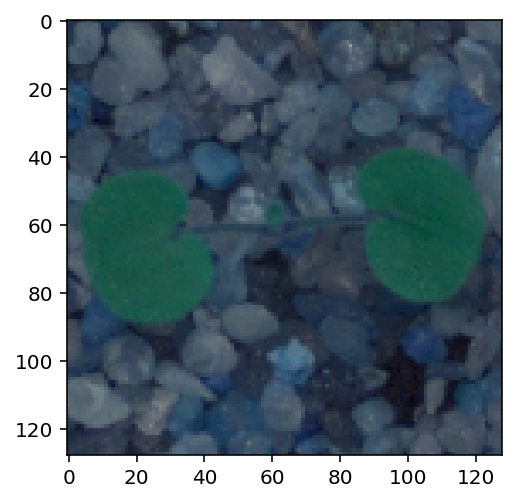

In [7]:
# Visualize an image
img = X[0]
plt.imshow(img)
# plt.title(y[0])

**Insights:** 
- The image dataset (X) containes 4750 images
- The image size is 128 x 128
- Each image has 3 colour channels.

### Data pre-processing
Here we will normalize the data and add Gaussian Blurring

In [8]:
# Normalize image pixels
X = X.astype('float32')
X /= 255.0

In [9]:
x_gaus_blur = np.copy(X)

In [10]:
# applying the gaussian blur to each 128x128 pixels array in each channel to reduce the noise in the image
for idx, img in enumerate(x_gaus_blur):
    x_gaus_blur[idx] = cv2.GaussianBlur(img, (5, 5), 0)

Text(0.5, 1.0, 'With Gaussian Blur')

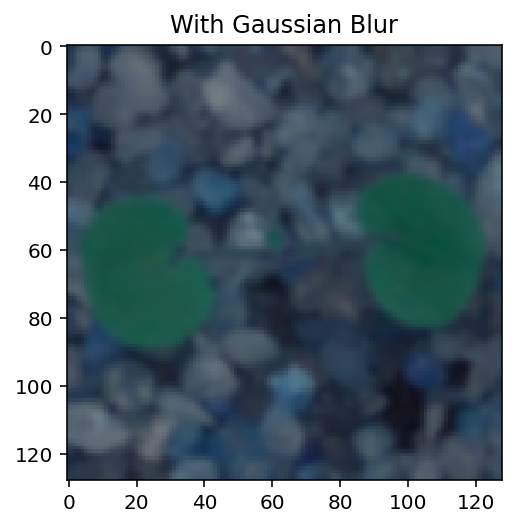

In [11]:
plt.imshow(x_gaus_blur[0])
plt.title('With Gaussian Blur')

Text(0.5, 1.0, 'Without Gaussian Blur')

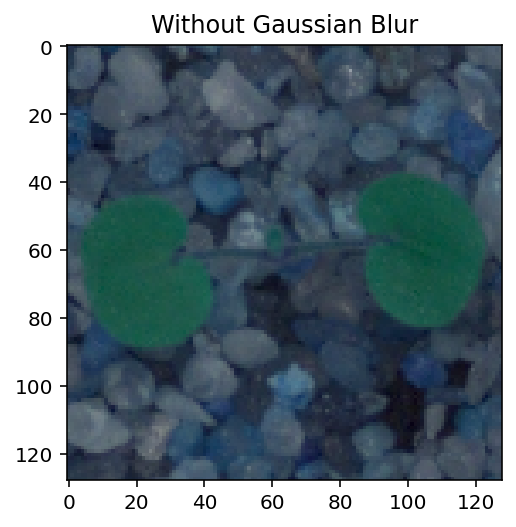

In [12]:
plt.imshow(X[0])
plt.title('Without Gaussian Blur')

### Make data compatible for tensorflow CNN and split into train, test, validation set

In [13]:
# Convert labels to one-hot-vectors
label_dict = {'Black-grass': 0,
              'Charlock': 1,
              'Cleavers': 2,
              'Common Chickweed': 3,
              'Common wheat': 4,
              'Fat Hen': 5,
              'Loose Silky-bent': 6,
              'Maize': 7,
              'Scentless Mayweed': 8,
              'Shepherds Purse': 9,
              'Small-flowered Cranesbill': 10,
              'Sugar beet': 11}

enc = LabelBinarizer()
y_label = enc.fit_transform(y)

print("Shape of y:", y_label.shape)
print("One value of y:", y_label[0])

Shape of y: (4750, 12)
One value of y: [0 0 0 0 0 0 0 0 0 0 1 0]


In [14]:
# Split the data into training and validation set
X_train, X_test_val, y_train, y_test_val = train_test_split(x_gaus_blur, y_label, test_size = 0.3, random_state = 7)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size = 0.5, random_state = 7)

In [15]:
# check the shape of the data
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test: ",X_test.shape)
print("y_train: ",y_train.shape)
print("y_val: ",y_val.shape)
print("y_test: ",y_test.shape)

X_train: (3325, 128, 128, 3)
X_val: (713, 128, 128, 3)
X_test:  (712, 128, 128, 3)
y_train:  (3325, 12)
y_val:  (713, 12)
y_test:  (712, 12)


`There is no need to reshape the data since it is already in the appropriate shape compatible with Keras models.`

### Building CNN

In [16]:

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation="relu", input_shape=X_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))


model.add(layers.GlobalMaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(12, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [17]:
# initiat Adam optimizer
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [18]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [19]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('plant_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

In [20]:
# fit the model
# Set the batch size, number of epochs.
batch_size = 32
num_classes = 12
epochs = 100

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping,model_checkpoint])



Epoch 1/100
104/104 [==============================] - 6s 34ms/step - loss: 3.4905 - accuracy: 0.0852 - val_loss: 2.4704 - val_accuracy: 0.1332

Epoch 00001: val_loss improved from inf to 2.47040, saving model to plant_cnn_checkpoint_01_loss2.4704.h5
Epoch 2/100
104/104 [==============================] - 3s 27ms/step - loss: 2.4393 - accuracy: 0.1380 - val_loss: 2.4489 - val_accuracy: 0.1753

Epoch 00002: val_loss improved from 2.47040 to 2.44891, saving model to plant_cnn_checkpoint_02_loss2.4489.h5
Epoch 3/100
104/104 [==============================] - 3s 27ms/step - loss: 2.2631 - accuracy: 0.2286 - val_loss: 2.4232 - val_accuracy: 0.1332

Epoch 00003: val_loss improved from 2.44891 to 2.42317, saving model to plant_cnn_checkpoint_03_loss2.4232.h5
Epoch 4/100
104/104 [==============================] - 3s 27ms/step - loss: 2.0604 - accuracy: 0.2870 - val_loss: 2.3533 - val_accuracy: 0.1893

Epoch 00004: val_loss improved from 2.42317 to 2.35327, saving model to plant_cnn_checkpoint_0

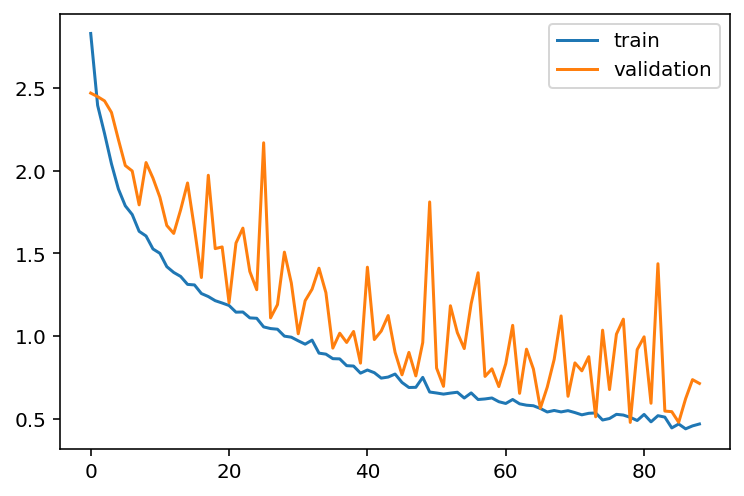

In [21]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [22]:
# evaluate trained model
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:',  scores[0])
print("Test accuracy:", scores[1])

23/23 [==============================] - 0s 11ms/step - loss: 0.6222 - accuracy: 0.7865
Test loss: 0.6221686601638794
Test accuracy: 0.7865168452262878


**insight**: 
Since we are getting a validation accuracy of 78.26% during training and an accuracy of 78.65% when applied on our test dataset, we can conclude that we did not overfit our model, and the accuracy is high enough to be useful.

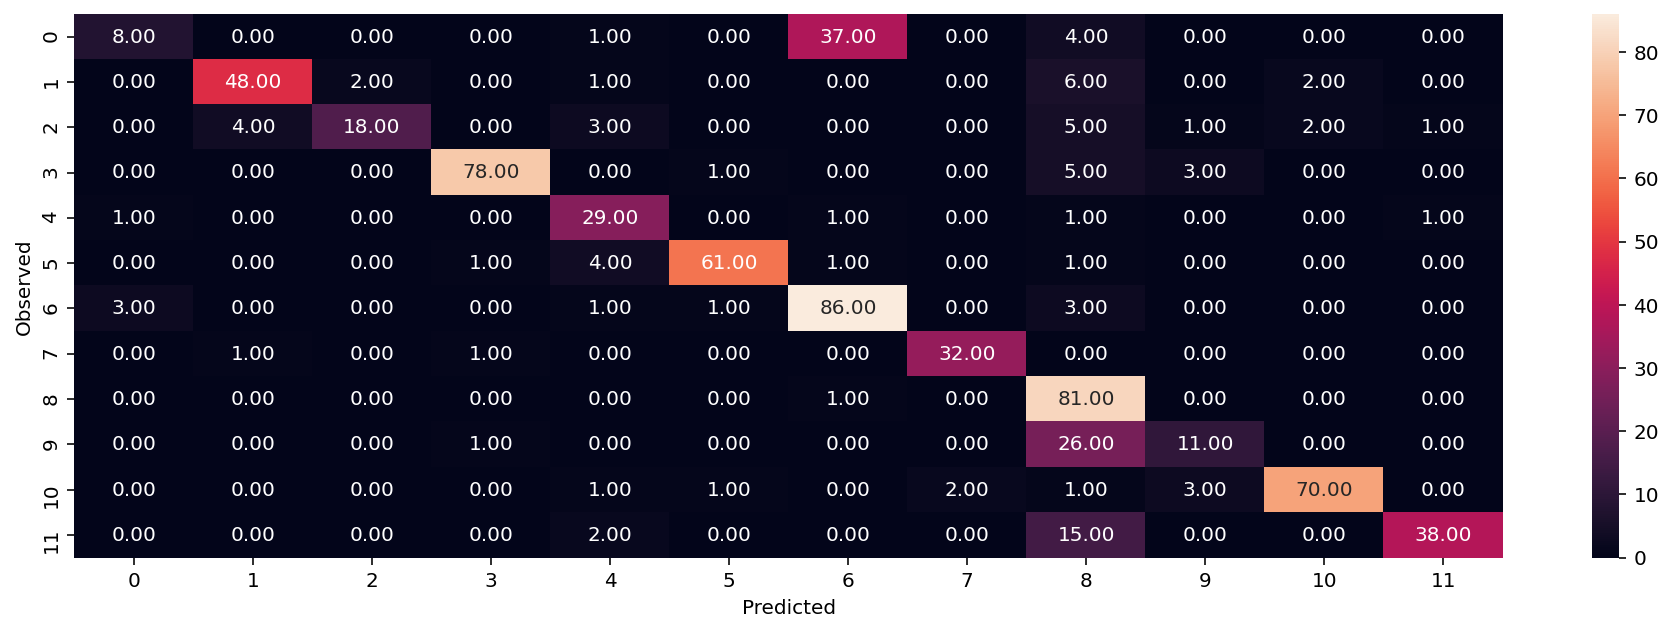

None


In [23]:
## function to get confusion matrix in a proper format
def draw_cm( actual, predicted ):
    cm = confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1,2,3,4,5,6,7,8,9,10,11] , yticklabels = [0,1,2,3,4,5,6,7,8,9,10,11] )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()
plt.figure(figsize=(16,5))
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print(draw_cm(y_test,y_pred))

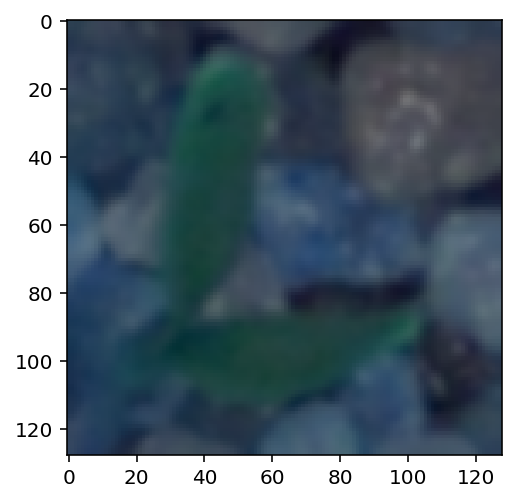

predicted label: Sugar beet
Actual label: Sugar beet


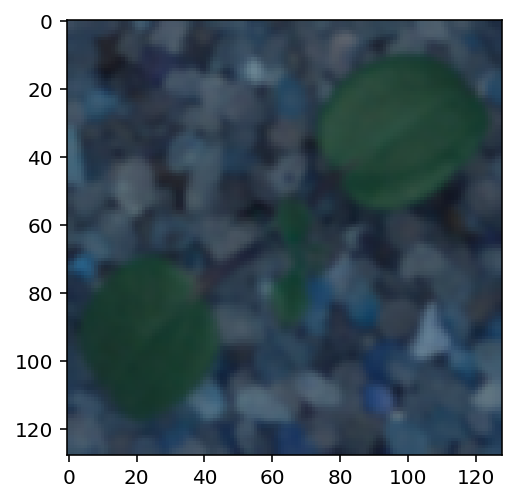

predicted label: Cleavers
Actual label: Cleavers


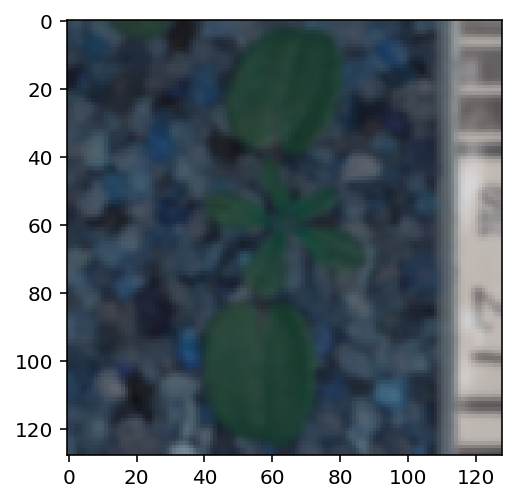

predicted label: Cleavers
Actual label: Cleavers


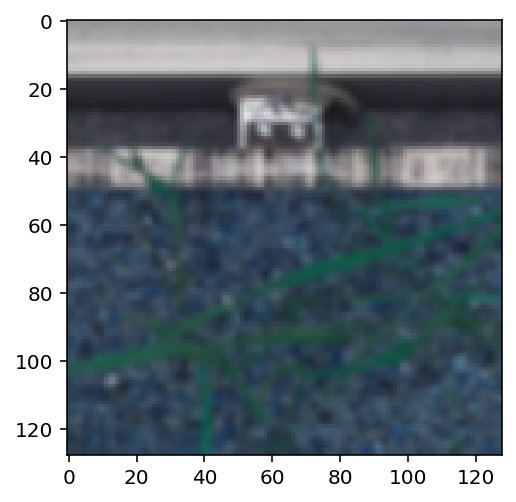

predicted label: Scentless Mayweed
Actual label: Black-grass


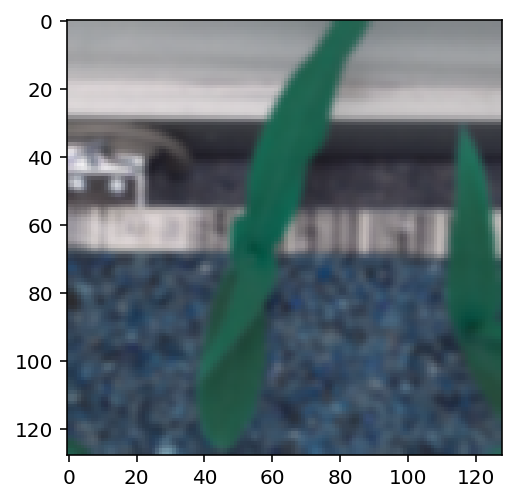

predicted label: Maize
Actual label: Maize


In [24]:
label_string = {
                0: 'Black-grass',
                1: 'Charlock',
                2: 'Cleavers',
                3: 'Common Chickweed',
                4: 'Common wheat',
                5: 'Fat Hen',
                6: 'Loose Silky-bent',
                7: 'Maize',
                8: 'Scentless Mayweed',
                9: 'Shepherds Purse',
                10: 'Small-flowered Cranesbill',
                11: 'Sugar beet'}

vis_predict = [2,3,33,36,59]
for i in vis_predict:
  plt.imshow(X_test[i])
  plt.show()
  y_pred = model.predict(X_test[i].reshape(1,128,128,3))
  print("predicted label:", label_string[y_pred.argmax()])
  print("Actual label:", label_string[y_test[i]])
  
